# Attention

*In this exercise we are going to work with attention. If you haven't heard, it has become **massively** important, mostly since transformers use it (and is part of what makes them the new black for everything).*

After these exercises (and the lecture), you should be able to (in rough order of importance):
- Understand what attention is
- Understand how attention is computed given inputs 
- Understand why it is often called 'self-attention'
- Understand how neural networks are used to get attention values
- Understand why attention is good to use
- Understand how attention differs from just embeddings

- Understand early (non learnable) vs newer learnable attention

**Note**: This notebook contains some code taken or adapted from 02456: Deep Learning, accessed from the [github repo](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch) at 16-11-2024. Some code snippets may differ from previously in the course as there hasn't been time to adapt it entirely for the course code structure.

## Quick introduction

# Fix indexing here

*In its most basic form, attention is a form of similarity measur applied to sequences of usually words. As you may know, the dot product is a rough measure of similarity between vectors. Let $\mathbf{y}$ be an input sequence of word embeddings, for example a sentence in english, and let $\mathbf{x}$ be the same sentence but in another language. The similarity between two words in either sequences will then be:*

$$e_{ij} = x^{(i)^T} y^{(j)}$$

*That is, how much word $\mathbf{x}^{(i)}$ relates to word $\mathbf{y}^{(j)}$ The softmax is then usually used to scale these values to be between 0 and 1, which gives the **attention weight** $W_{ij}$ between word $i$ and $j$*:

$$W_{ij} = \text{softmax}\left(\mathbf{x}^{(i)^T} \mathbf{y}^{(j)}\right)$$

*After this, the **attention weights** $W_{ij}$ can then be used on each word of the input sentence, to get the final **attention reprsentations**:*

$$\mathbf{o}{(i)} = \sum^T_{j = 0} W_{ij} \mathbf{x}^{(j)}$$

*The result $o^{(i)}$, will then be **a vector** representing how much each word in the input sentence relates to **a word** in the output sentence. If we wanted to get an attention value **from each word** to **each word** we would need a matrix, which would be the whole $o$*

## Improved (learnable) attention

*Introduced primarily in [attention is all you need](https://arxiv.org/abs/1706.03762), self attention improves 'regular' attention by adding learnable parameters to the attention.*

*Note that above, the attention values only depended on the similarity between words, meaning words embedded with similar values also got high attention scores. This doesn't make sense for many tasks, particularly in translation, since some words in sentences can relate a lot to others despite being different, consider the sentence:*

***Mary saw a dog in the window, she wanted it***

*Logically, we can think the words (Mary, saw, wanted, it), (dog, it), (in, window) fit together as they describe the relationship that Mary wanted **it** "it" meaning "the dog" (not the window). This would not be caught by the above method, since it is uncommon that "it" and "dog" are very similar words...*

*The solution is to use **self-attention**. Here we maintain three new embedding values for each word: $\mathbf{Q}$ (queries), $\mathbf{K}$ (keys), and $\mathbf{V}$ (values). Do not worrry about the names.* 

*We train these three embeddings much the same way as we would word embeddings in, say Fasttext. However, they are not specifically embeddings. **They work on embeddings**. To get $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ for one input sentence (of words!!) $\mathbf{s}$, we first get a word embedding of that input sentence, and then multiply that matrix with matrices for each $\mathbf{Q}, \mathbf{K}, \mathbf{V}$:*

$$\mathbf{Q} = \text{embedding}(\mathbf{s})W_Q,\quad \mathbf{K} = \text{embedding}(\mathbf{s})W_K, \quad \mathbf{V} = \text{embedding}(\mathbf{s})W_V$$

*We then calculate the full attention matrix:*

$$\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left( \frac{\mathbf{Q} \mathbf{K}^T}{\sqrt{d_k}} \right) \mathbf{V}$$

*The reason we scale by $\sqrt{d_k}$ (which is either based on the dimension of $W_K$, chosen arbitrarily, or based on the number of 'heads' for multi-head attention), is simply to avoid exploding gradients (don't worry too much about it)...*

## Difference between attention **weights** and attended **representations**

*It must be specified, that we differentiate between **attention weights** $W$, and the**attended representations** $O$. The attention weights are often the ones examined to find out what a model thinks about a specific sentence, since it is a matrix of dimension $(\text{sentence 1 length}, \text{sentence 2 length})$. The attended representations, however, are of dimension $(\text{sentence 1 length}, \text{embedding dim})$, making it much harder to make sense of.*


In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn
import torch.nn.functional as F
import zipfile

from pathlib import Path
from typing import List, Tuple

# TODO: Remember to add these to the requirements file
import tokenizers

from huggingface_hub import hf_hub_download

In [2]:
# Following is just functions to get glove vectors and such

def load_glove_vectors(filename = "glove.6B.50d.txt") -> Tuple[List[str], torch.Tensor]:
    """Download and load GloVe vectors, returns both vocabulary and GloVe vectors"""
    # TODO: Add warning here in case download fails
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r", encoding="utf8") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

# tokenizer for GloVe - simplifies a lot of things
# Such as when passing to transformers or when handling unknown tokens
glove_vocabulary, glove_vectors = load_glove_vectors()
glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)}, unk_token="<|unknown|>"))
glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

embeddings = torch.nn.Embedding(*glove_vectors.shape)
embeddings.weight.data = glove_vectors
embeddings.weight.requires_grad = False

def words_to_glove(sentence: List[str]) -> torch.Tensor:
    """
    Slightly more sophisticated method of getting GloVe vectors

    Note: Returns torch tensors!
    """

    # Just handle in case user forgot that input needs to be a list
    if type(sentence) == str:
        sentence = sentence.split() 

    encodings = glove_tokenizer.encode_batch(sentence)
    vectors = [embeddings(torch.tensor(e.ids)).mean(dim=0) for e in encodings]
    return torch.stack(vectors)

# Test the function works
sentence_example = 'snug as bug in a rug!'
print(words_to_glove(sentence_example).shape)


Parsing glove.6B.50d.txt...: 100%|██████████| 400001/400001 [00:06<00:00, 66196.47it/s]


torch.Size([6, 50])


## 1 - Calculating attention

*Here we are going to use a few mockup examples of sentences with GloVe embeddings to generate attention values between sentences*

**1. Complete the below function to calculate just the simple attention weights between two word vectors. That is, we want the attention from each word in sentence_1 to each word in sentence_2**

**2. In general given one sentence of $N$ words and a second sentence of $M$ words, what dimension should the attention from the first sentence to the second sentence be?**

$\dots$

**3. Complete the function to get the attended representations using the previously calculated attention weights**

**4. Reason about what attention vs the attended representations can be used for...**

$\dots$

In [ ]:
def simple_attention_weights(vec_1, vec_2):
    """
    Computes simple attention scores between two sentences

    Returns an N X M attention map where N, M are the lengths of sentence 1 and 2 respectively
    """

    # Initalize empty attention map
    attention_map = ...

    # For each word (vector) in sentence 1
    for i in range(len(vec_1)):
        # Iterate over all word (vectors) in sentence 2
        for j in range(len(vec_2)):
            # And compute the attention score by dot product
            ...

    # Apply softmax to attention map to get final attention
    attention_map = ...

    return attention_map

def attended_representation(vec_1, vec_2, attention_weights):
        attended_representations = np.zeros_like(vec_1)
        for i in range(len(vec_1)):
            for j in range(len(vec_2)):
                # print(attended_representations[i] + 5)
                ...

        return attended_representations
    


In [4]:
# Two example sentences
sentence_1 = 'a cat in a hat'
sentence_2 = 'a bug in a rug hat'

# Get the word vectors, we un-torch them here, otherwise we'll run into issues with numpy vs torch
vec_1 = words_to_glove(sentence_1).detach().numpy()
vec_2 = words_to_glove(sentence_2).detach().numpy()

# Get the attention weights
attention_weights = simple_attention_weights(vec_1, vec_2)

print("Dimensionality of attention weights is:", attention_weights.shape)
print("Attention weights are:", attention_weights)


Dimensionality of attention weights is: (5, 6)
Attention weights are: [[4.99783642e-01 1.03114718e-09 4.32009904e-04 4.99783642e-01
  2.92794989e-11 7.04313235e-07]
 [1.08686499e-01 3.98873452e-01 1.09872575e-03 1.08686499e-01
  2.00355862e-03 3.80651266e-01]
 [2.06731747e-02 4.35277591e-09 9.58653562e-01 2.06731747e-02
  1.69017570e-10 8.43275907e-08]
 [4.99783642e-01 1.03114718e-09 4.32009904e-04 4.99783642e-01
  2.92794989e-11 7.04313235e-07]
 [1.53757139e-04 1.66524258e-07 3.84703078e-07 1.53757139e-04
  3.84849320e-06 9.99688086e-01]]


In [5]:
# Get the attended representations, no reason to print anything other than their dimension
attended_representations = attended_representation(vec_1, vec_2, attention_weights=attention_weights)

print("Dimensionality of attended_representations is:", attended_representations.shape)

Dimensionality of attended_representations is: (5, 50)


## 2 - Visualizing attention

*Often we want to see how our model attends each word in a sentence related to one another. Ours is quite simple, since it only relies on word embeddings, still there may be cool things to uncover...*

**1. Use the below function to plot the previously calculated attention weights, where is attention large? Where is it small, and why?**

$\dots$

**2. Is there potentially a scaling issue when using attention in this manner? (HINT: Why does 'a'-'a' have a smaller attention value than 'snug'-'snug'?)**

$\dots$

**$\star$ 3. Reason a bit about how you *could* use this attention mechanism for NLP purposes**

$\dots$

In [6]:
def visualize_attention(attention_map, sentence_1: list[str], sentence_2: list[str], head: int=None):
    """
    Visualize the attention map between two sentences.
    
    Parameters:
        attention_map (numpy.ndarray): 2D array with attention weights. Shape: (len(sentence1), len(sentence2))
        sentence1 (list of str): The first sentence, tokenized into words.
        sentence2 (list of str): The second sentence, tokenized into words.
    """

    if head is not None:
        attention_map = attention_map[head]
    
    # Ensure the attention map dimensions match the sentences
    assert attention_map.shape == (len(sentence_1), len(sentence_2)), (
        "Attention map shape must match sentence lengths"
    )
    
    fig, ax = plt.subplots(figsize=(len(sentence_1), len(sentence_2)))
    cax = ax.matshow(attention_map, cmap='viridis', aspect='auto')
    
    # Add color bar
    plt.colorbar(cax, ax=ax, orientation='vertical')
    
    # Set up ticks and labels
    ax.set_xticks(np.arange(len(sentence_2)))
    ax.set_yticks(np.arange(len(sentence_1)))
    ax.set_xticklabels(sentence_2, rotation=90, fontsize=10)
    ax.set_yticklabels(sentence_1, fontsize=10)
    
    # Add labels for clarity
    ax.set_xlabel('Words in Sentence 2', fontsize=12)
    ax.set_ylabel('Words in Sentence 1', fontsize=12)
    plt.title('Attention Map', fontsize=14)
    
    if head is not None:
        plt.title(f'Attention Map for head {head}', fontsize=14)
        
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_97962/3029508644.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  attention_map[i, j] = vec_1[i].T @ vec_2[j]


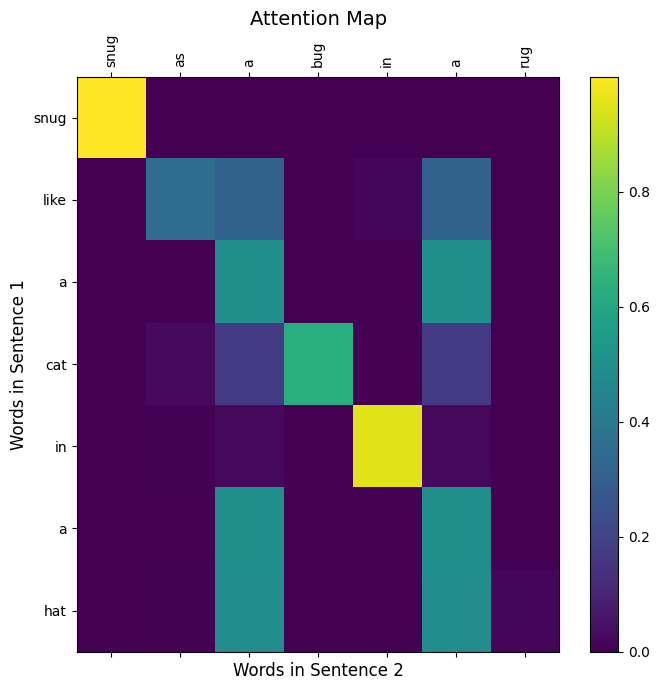

In [7]:
# Test attention map function with examples from before
sentence_1 = 'snug like a cat in a hat'
sentence_2 = 'snug as a bug in a rug'

vec_1 = words_to_glove(sentence_1)
vec_2 = words_to_glove(sentence_2)

attention_map = simple_attention_weights(vec_1, vec_2)
visualize_attention(attention_map, sentence_1.split(), sentence_2.split())

## $\star$ 3 - Creating a vocabulary

*NLP usually requires a ton of preprocessing, which we really cannot be bothered to do. However, DTU lacks a proper NLP course, so there aren't many places to practice it...*

**1. $\star$ $\star$ $\star$ Do the thing we cannot be bothered to do: Perform some of the preprocessing by completing the function to build a vocabulary from a list of sentences**

**If you do not want to do it, just copy the build_vocabulary function from the solutions**

In [ ]:
# Define embedding matrices
# Here, we use torch's embedding class, since it is just a bit closer to what you'd normally use in this case

def build_vocabulary(sentences, oov_token='OOV'):
    
    # Make a set to represent our vocabulary
    # A set is like a dict with keys, but no values
    # Really more like a list that cannot have duplicates
    vocab = set()
    
    # Iterate through sentences, lower and split the sentences to obtain lists of words used, add these to vocab
    ...
    
    # Update vocab with only special token we use, OOV - out of vocabulary
    vocab.update([oov_token])

    # Wort vocab just to have it be nicer to look around    
    vocab = sorted(vocab)

    # Create dictionaries for word_to_index and index_to_word that given a word in the vocab returns the index or vice versa for in
    word_to_index = ...
    index_to_word = ...

    # Define function for getting tokens from a sentence, should return OOV if word is not in vocab
    def tokens_to_indices(tokens):
        return ...
    
    return tokens_to_indices, word_to_index, index_to_word, vocab   

# Define completely random sentences to have a vocabulary
sentences = [
    "He turned himself into a pickle",
    "Sphinx of Black Quartz, Judge My Vow",
    "Skibidi dum dum yes yes",
    "The brain is rotting on the poles",
    "Release me from this flesh prison mortal fool",
    "I submit myself willingly to our artificial overlords",
    "One day the crude biomass that you call a temple will wither and you will beg my kind to save you",
    "For everything to be consummated for me to feel less alone I had only to wish that there be a large crowd of spectators the day of my execution and that they greet me with cries of hate"
]

# Create vocab based on sentences:
tokens_to_indices, word_to_index, index_to_word, vocab = build_vocabulary(sentences=sentences)

# Create a new sentence by randomly sampling from vocab...
new_sentence = " ".join(np.random.choice(vocab, 5))
# Add extra word just to showcase OOV tokens also being used
new_sentence += " factorio"
print("Random sentence is", new_sentence)

# Get tokens from the new sentence:
tokens = new_sentence.lower().split()
print(new_sentence, tokens)
token_indices = tokens_to_indices(tokens)

print("Token indices are", token_indices)

print([index_to_word[i] for i in token_indices])



Random sentence is a to kind only save factorio
a to kind only save factorio ['a', 'to', 'kind', 'only', 'save', 'factorio']
Token indices are [1, 63, 33, 43, 52, 0]
['a', 'to', 'kind', 'only', 'save', 'OOV']


### 4 - The actual attention part

*The 'groundbreaking' paper [Attention is all you need](https://arxiv.org/abs/1706.03762), orignally proposed using matrices of Queries, Keys and Values, along with multiheaded attention. We will attempt to do the same, albeit without training an actual model*

*The reason we don't train a model is because it is really time consuming, and NLP requires tons of preprocessing that we (as mentioned), really cannot be bothered to do right now...*

*Here we are going to build a simple attention module using torch, that does not train, and simply uses randomly initialized weights*

**1. Complete the attention_module code by implementing the attention_from_tokens function, test that it works by running the code cell two steps below, remember attention should be $(\text{sentence length}, \text{sentence length})$ should be $(\text{sentence length}, \text{V dim})$**

**2. Does the attention make sense? Does it hold any kind of interesting information whatsoever? Why/Why not?**

$\dots$

**3. Could we expect better results by using pretrained GloVe as our word embeddings while keeping the Q, K and V matrices the same? Why/Why not?**

$\dots$

**4. Complete the code to implement multi headed attention, test its functionality by running the code three cells below. Below are a few suggestions on how you can do this (there is no correct way!):**

1. Have a list of query_, key_ and value_embeddings, do the same calculation and for single head in list comprehension or in a for loop
2. Have query_, key_ and value_embedding dimensions be scaled by the number of heads, you can then reshape the resulting tensor to get (num_heads, sentence_length, V_dim), then pass this to a linaer layer or aggregation function

- NOTE: In either case, you should implement a linear layer to aggregate the results of all heads to a vector $sentence_length, V_dim$ in dimensions

Feel free to take inspiration from the solution, but try to understand it


**5. What are the advantages of using a linear layer to aggregate the results of all attention heads, compared to just using like the mean or something?**

$\dots$


In [ ]:
class AttentionModule:
    def __init__(self, word_dim, Q_dim, K_dim, V_dim):
        # Create dummy embedding layer for word embeddings:
        # A torch embedding layer is just like a linear layer that only takes tensors of integers (technically torch.long values)
        self.word_embeddings = ...

        # Define weight matrices for Queries, Keys and Values
        # Unlike the word embeddings, these need to work on torch tensors, so they are just linear layers, despite being used much like embeddings
        self.query_embeddings = ...
        self.key_embeddings = ...
        self.value_embeddings = ...
        
        # Keep track of K_dim for scaling factors, otherwise handled by number of heads in multihead attention
        self.K_dim = K_dim
        
    def attention_from_tokens(self, token_indices):
        # Transform to tensor to allow or use in word_embeddings:
        token_indices_tensor = torch.tensor(token_indices)
        embeddings = self.word_embeddings(token_indices_tensor)

        attention = ...

        representations = ...
        
        return attention, representations

# Just define Multi head attention as subclass of Attention module
class MultiHeadAttentionModule(AttentionModule):
    def __init__(self, word_dim, Q_dim, K_dim, V_dim, num_heads=1):
        super().__init__(word_dim, Q_dim, K_dim, V_dim)

        # Difference from Attention Module, actually has a number of heads
        self.num_heads = num_heads
                
        # This time, we define our query, key, and value embeddings extra according to number of heads 
        # Technically we should have a [num_heads, word_dim, Q_dim] dimensional vector, but torch is limited in only allowing 2-dimensional linear layers...
        # ... so we just increase the number of Q_dims and then we can reshape afterwards
        self.query_embeddings = ...
        self.key_embeddings = ...
        self.value_embeddings = ...
        
        # This time, we actually need all of our Q, K and V dims for reshaping purposes...
        self.Q_dim = Q_dim
        self.K_dim = K_dim
        self.V_dim = V_dim

        # Final linear layer to combine all contexts into one context...
        self.linear_layer = ...
        
    def attention_from_tokens(self, token_indices):
        # Transform to tensor to allow or use in word_embeddings:
        token_indices_tensor = torch.tensor(token_indices)
        embeddings = self.word_embeddings(token_indices_tensor)

        # Then we can get our multihead attention
        queries = ...
        keys = ...
        values = ...
        
        # Get our queries dotted with our keys
        queries_dot_keys = ...
        
        # Get the multihead_attention and multihead_representations
        heads_attention = ...
        heads_representations = ...
        
        # Finally, pass through linear layer as a kind of aggregation...
        final_representations = ...
        
        return heads_attention, final_representations



a to kind only save factorio
None
Attention dimensionality is: torch.Size([6, 6])
After context layer (dotting with values, dimension is): torch.Size([6, 50])


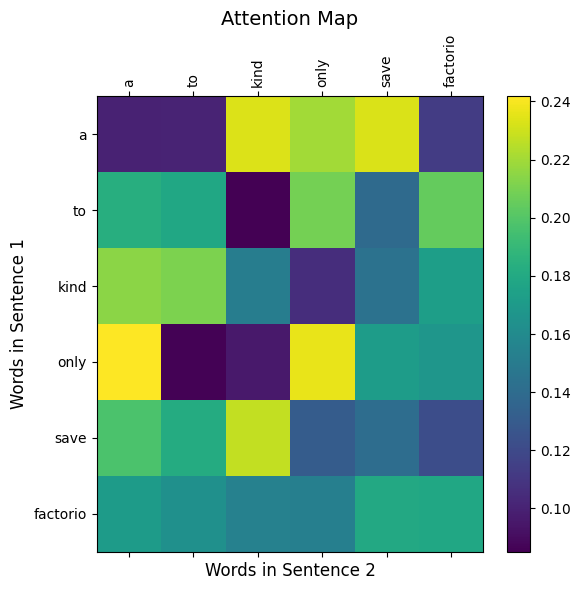

In [ ]:
# Define dimensions of word embeddings, as well as Q, K and V matrices
word_dim = 50
Q_dim = 50
K_dim = 50
V_dim = 50

# Instantiate AttentionModule
attention_model = AttentionModule(word_dim, Q_dim, K_dim, V_dim)

# Print sentence we are getting attention for
print(print(new_sentence))

# Calculate the attention and context layer values
attention, representations = attention_model.attention_from_tokens(token_indices)

# Print and visualize
print("Attention dimensionality is:", attention.shape)
print("After context layer (dotting with values, dimension is):", representations.shape)

visualize_attention(attention.detach().numpy(), new_sentence.split(), new_sentence.split())

Attention dimensionality is: torch.Size([3, 6, 6])
After context layer (dotting with values, dimension is): torch.Size([6, 50])


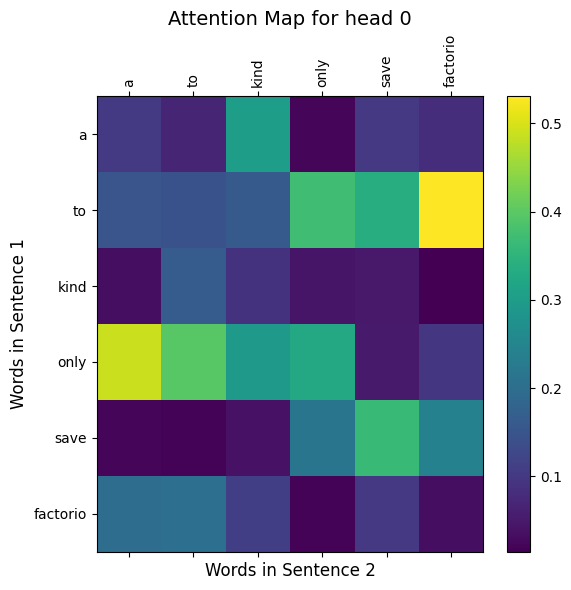

In [11]:
num_heads = 3

# Instantiate MultiHeadAttentionModule
multihead_attention_model = MultiHeadAttentionModule(word_dim, Q_dim, K_dim, V_dim, num_heads=num_heads)


# Calculate the attention and context layer values
multihead_attention, multihead_representations = multihead_attention_model.attention_from_tokens(token_indices)

# Print and visualize
print("Attention dimensionality is:", multihead_attention.shape)
print("After context layer (dotting with values, dimension is):", multihead_representations.shape)
visualize_attention(multihead_attention.detach().numpy(), new_sentence.split(), new_sentence.split(), head=0)

## $\star$ 5 - More in-depth view of attention

*While trying to make som really cool representaion of attention, I almost forgot the creed of the KID student... But then I remembered, and found [this cool visualization notebook](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing) located in [this repository: bertviz](https://github.com/jessevig/bertviz). It uses a pretrained Bert transformer **with** positional encodings (next week stuff). It also has multiple attention layers, so doesn't just produce one attention map.*

**1. Look around the provided notebook and see if you get smarter on attention mechanisms, remember Bert has multiple heads across multiple layers that each produce attention!**

- NOTE: You do not need to run anything, the visuzliations are already there, preloaded

**$\star$ $\star$ $\star$ $\star$ $\star$ $\star$ $\star$ 2. Say something nice to the person next to you. How did they respond?**

$\dots$